In [ ]:
from shared.img_to_graph import img_to_graph
import torch
from _04_mnist_digits.graph_dataset import GraphDataset
import os

savedir = "_05_ct_images/data"
images = torch.load(savedir + "/augmented_images.pt")
labels = torch.load(savedir + "/augmented_labels.pt")
print(f"Loaded augmented images shape: {images.shape}")
print(f"Loaded augmented labels shape: {labels.shape}")

Loaded augmented images shape: torch.Size([10000, 224, 224])
Loaded augmented labels shape: torch.Size([10000])


In [ ]:
if os.path.exists(savedir + "/dataset1000.pt"):
    print("Dataset already exists, skipping creation.")
    dataset = torch.load(savedir + "/dataset1000.pt", weights_only=False)
    print(type(dataset))
else:
    IMAGES_TO_SAVE = 1000
    dataset = GraphDataset(images[:IMAGES_TO_SAVE], labels[:IMAGES_TO_SAVE], use_weighted_edges=False)

    torch.save(dataset, savedir + "/dataset1000.pt")

Dataset already exists, skipping creation.
<class '_04_mnist_digits.graph_dataset.GraphDataset'>


In [3]:
print(dataset[0])

Data(x=[3487], edge_index=[2, 14327], y=3, edge_weight=[2])


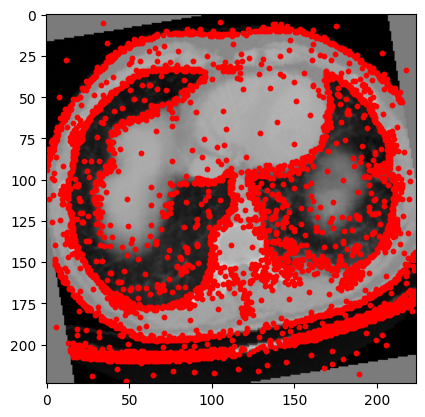

In [4]:
import matplotlib.pyplot as plt
img = images[0]
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
plt.imshow(img.numpy(), cmap='gray')
plt.scatter(dataset.centroids[0][:, 1].numpy(), dataset.centroids[0][:, 0].numpy(), c='red', s=10, label='Centroids')

In [5]:
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

class GraphDatasetWithCentroids(Dataset):
    def __init__(self, Xs, centroids, edge_indices=None, edge_weights=None, labels=None):
        super().__init__()
        self.Xs = Xs
        self.centroids = centroids
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.labels = labels
    
    def len(self):
        return len(self.Xs)
    
    def get(self, idx):
        return Data(x=torch.cat((self.Xs[idx].unsqueeze(-1), self.centroids[idx]), dim=1), # (Nnodes, 1) + (Nnodes, 2)
        edge_index=self.edge_indices[idx].T, # (2, Nedges)
        edge_weight=self.edge_weights[idx],
        y=self.labels[idx])

new_dataset = GraphDatasetWithCentroids(dataset.Xs, dataset.centroids, dataset.edge_indices, dataset.edge_weights, dataset.labels)

In [6]:
dataset = new_dataset

example_x = dataset[0].x
if example_x.dim() == 2:
    num_features = example_x.shape[1]  # Set the number of features
else:
    num_features = 1

num_classes = len(set(dataset.labels.tolist()))  # Set the number of classes

datasets = {}
loaders = {}

for split, dataset in zip(["train", "val", "test"], torch.utils.data.random_split(dataset, (0.7, 0.15, 0.15))):
    datasets[split] = dataset
    loaders[split] = DataLoader(dataset, batch_size=(32 if split == "train" else len(dataset)), shuffle=(split == "train"))

In [7]:
print(datasets["train"][0])

Data(x=[3531, 3], edge_index=[2, 14748], y=3, edge_weight=[2])


In [8]:
from torch_geometric.nn import EdgeCNN, summary
from shared.models.GNNClassifier import GNNClassifier
import torch_geometric.nn as nn
from shared.training import train_classifier


class Classifier(GNNClassifier):
    def __init__(self, in_channels, num_classes, num_layers, hidden_channels, **kwargs):
        super().__init__(num_node_features=in_channels,
                        num_classes=num_classes,
                        hidden_ch=hidden_channels,
                        **kwargs)
        self.edgecnn = EdgeCNN(in_channels=in_channels,
                               num_layers=num_layers,
                               hidden_channels=hidden_channels,
                               )

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.edgecnn(x, edge_index, edge_weight=edge_weight)

        # Use PyTorch Geometric's global_max_pool which handles batching correctly
        if batch is None:
            # If no batch info, assume single graph
            x = torch.max(x, dim=0, keepdim=True).values
        else:
            # Proper batched global pooling
            x = nn.global_max_pool(x, batch)
        
        x = self.mlp(x)
        return x
    
    def get_model_inputs_from_batch(self, batch):
        return 

model = Classifier(in_channels=num_features,
                num_classes=4,
                num_layers=3,
                hidden_channels=128,
                fc_layers=3,
                fc_hidden_dim=128)

model.get_model_inputs_from_batch = lambda batch: (batch.x, batch.edge_index, batch.batch)


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in loaders["train"]:
    print(batch)
    print([x.shape for x in model.get_model_inputs_from_batch(batch)])
    print(summary(model, *model.get_model_inputs_from_batch(batch)))
    break

print(model)

DataBatch(x=[106715, 3], edge_index=[2, 441801], y=[32], edge_weight=[64], batch=[106715], ptr=[33])
[torch.Size([106715, 3]), torch.Size([2, 441801]), torch.Size([106715])]
+----------------------------+------------------------------------+----------------+----------+
| Layer                      | Input Shape                        | Output Shape   | #Param   |
|----------------------------+------------------------------------+----------------+----------|
| Classifier                 | [106715, 3], [2, 441801], [106715] | [32, 4]        | 216,452  |
| ├─(convolutions)ModuleList | --                                 | --             | 66,688   |
| │    └─(0)GraphConv        | --                                 | --             | 896      |
| │    └─(1)GraphConv        | --                                 | --             | 32,896   |
| │    └─(2)GraphConv        | --                                 | --             | 32,896   |
| ├─(mlp)Sequential          | [32, 128]                  

In [9]:
overall_train_acc, overall_val_acc = train_classifier(N_epochs=25,
                                                    model=model,
                                                    train_dataloader=loaders["train"],
                                                    val_dataloader=loaders["val"],
                                                    loss=loss,
                                                    optimizer=optimizer,
                                                    )

Epoch    T Loss  T Acc  V Loss  V Acc

1/25     1.381   0.321   1.327   0.387
2/25     1.376   0.323   1.335   0.387
3/25     1.371   0.323   1.349   0.387
4/25     1.361   0.323   1.334   0.373
5/25     1.350   0.348   1.309   0.367
6/25     1.338   0.337   1.266   0.387
7/25     1.311   0.370   1.297   0.373
8/25     1.323   0.365   1.309   0.393
9/25     1.292   0.385   1.292   0.400
10/25    1.294   0.380   1.283   0.387
11/25    1.269   0.402   1.303   0.347
12/25    1.230   0.409   1.232   0.413
13/25    1.246   0.395   1.210   0.467
14/25    1.197   0.414   1.343   0.353
15/25    1.212   0.408   1.193   0.453
16/25    1.136   0.448   1.248   0.233
17/25    1.151   0.442   1.151   0.447
18/25    1.148   0.441   1.124   0.487
19/25    1.067   0.498   1.145   0.433
20/25    1.101   0.470   1.199   0.453
21/25    1.025   0.485   1.133   0.440
22/25    1.002   0.510   1.133   0.460
23/25    1.002   0.505   1.214   0.447
24/25    0.990   0.498   1.339   0.393
25/25    0.939   0.541   

In [10]:
torch.save(model.state_dict(), "_04_mnist_digits/models/EdgeCNN_unweighted_with_centroids.pt")

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for batch in loaders["test"]:
    y_true = batch.y
    y_pred = model(*model.get_model_inputs_from_batch(batch)).argmax(dim=1)
    print(classification_report(y_true, y_pred, digits=4, target_names=[str(i) for i in range(4)]))

    mat = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.3235    0.2037    0.2500        54
           1     0.2778    0.3571    0.3125        28
           2     0.6471    0.6875    0.6667        32
           3     0.2826    0.3611    0.3171        36

    accuracy                         0.3733       150
   macro avg     0.3827    0.4024    0.3866       150
weighted avg     0.3742    0.3733    0.3667       150



Text(0.5, 63.583333333333314, 'Predicted')

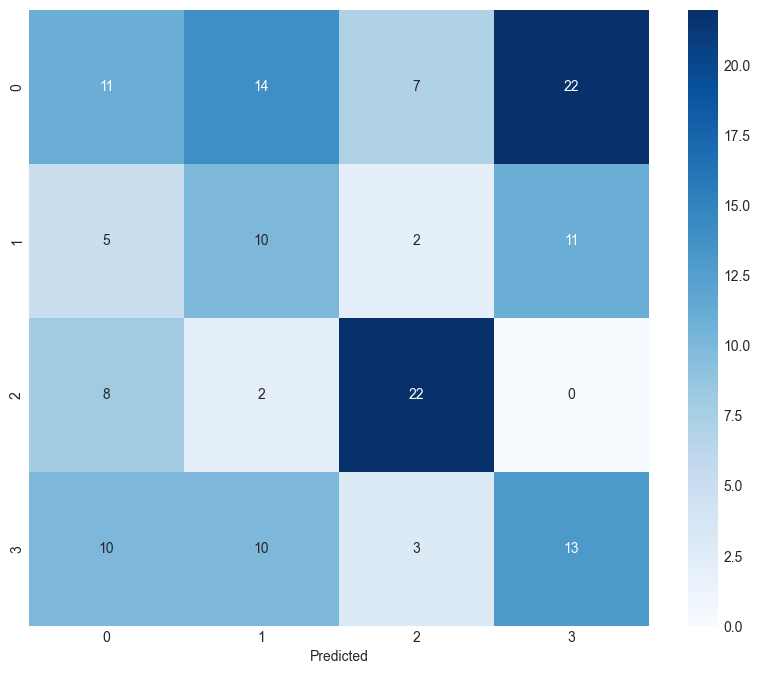

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(4)],
            yticklabels=[str(i) for i in range(4)])
plt.xlabel('Predicted')

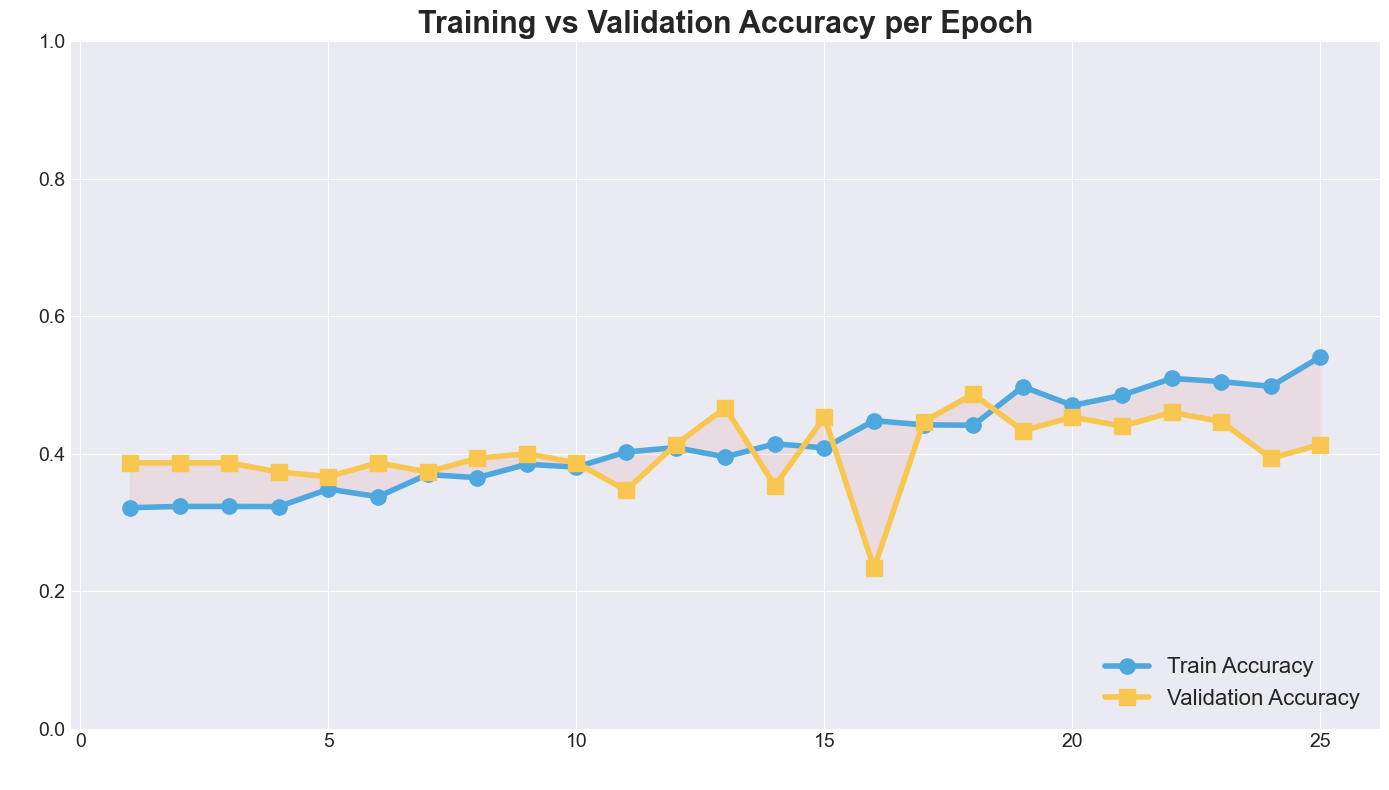

In [16]:
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

epochs = range(1, len(overall_train_acc) + 1)

plt.plot(epochs, overall_train_acc, label='Train Accuracy', linewidth=4, marker='o', color='#4ea8de', markersize=11)
plt.plot(epochs, overall_val_acc, label='Validation Accuracy', linewidth=4, marker='s', color='#f9c74f', markersize=11)

# Highlight the area between curves for clarity
plt.fill_between(epochs, overall_train_acc, overall_val_acc, color="#e08888", alpha=0.15)

plt.xlabel('Epoch', fontsize=18, color='white', weight='bold')
plt.ylabel('Accuracy', fontsize=18, color='white', weight='bold')
plt.title('Training vs Validation Accuracy per Epoch', fontsize=22, weight='bold')
plt.legend(loc='lower right', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [34]:
y_true = torch.cat([batch.y for batch in loaders["test"]])
y_pred = torch.cat([model(*model.get_model_inputs_from_batch(batch)) for batch in loaders["test"]])

In [36]:
print(y_true[:10])
print(y_pred[:10])

y_pred = torch.nn.functional.softmax(y_pred, dim=1)
print(y_pred[:10])

tensor([3, 0, 0, 3, 0, 2, 2, 1, 1, 1])
tensor([[ 2.0163,  2.3816, -5.4284,  2.3381],
        [ 2.0795,  2.0955, -5.1767,  2.5293],
        [ 2.8080,  2.9380, -7.1787,  3.5059],
        [ 1.0246,  0.9009, -1.5855,  0.6505],
        [ 2.1795,  1.4058, -4.3941,  2.4676],
        [ 0.5657, -0.6123,  1.8717, -0.5752],
        [-0.0504, -0.7585,  2.8255, -0.9162],
        [ 1.2635,  1.7400, -3.4337,  1.3734],
        [ 1.5202,  1.6108, -3.7349,  1.3940],
        [ 0.9055,  1.2159, -1.7291,  0.1466]], grad_fn=<SliceBackward0>)
tensor([[2.6171e-01, 3.7709e-01, 1.5297e-04, 3.6105e-01],
        [2.7895e-01, 2.8345e-01, 1.9688e-04, 4.3740e-01],
        [2.4105e-01, 2.7452e-01, 1.1090e-05, 4.8442e-01],
        [3.7805e-01, 3.3408e-01, 2.7797e-02, 2.6008e-01],
        [3.5758e-01, 1.6495e-01, 4.9944e-04, 4.7697e-01],
        [1.8802e-01, 5.7891e-02, 6.9401e-01, 6.0078e-02],
        [5.0880e-02, 2.5062e-02, 9.0265e-01, 2.1405e-02],
        [2.6768e-01, 4.3110e-01, 2.4416e-03, 2.9878e-01],
        [3

In [38]:
print(y_pred.sum(axis=1)[:10])

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SliceBackward0>)


tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0], dtype=torch.int32)
[0.2617078  0.27894726 0.2410531  0.3780456  0.35758463 0.18801977
 0.05088004 0.26768103 0.33540326 0.34434718]
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=torch.int32)
[0.37709212 0.2834547  0.27451834 0.3340796  0.16494611 0.05789069
 0.02506213 0.43109962 0.367211   0.46971384]
tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=torch.int32)
[1.5296704e-04 1.9688024e-04 1.1090259e-05 2.7796501e-02 4.9943716e-04
 6.9401127e-01 9.0265310e-01 2.4415525e-03 1.7510020e-03 2.4707051e-02]
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
[0.3610471  0.43740112 0.48441747 0.2600783  0.47696984 0.06007828
 0.02140475 0.29877785 0.29563478 0.16123195]


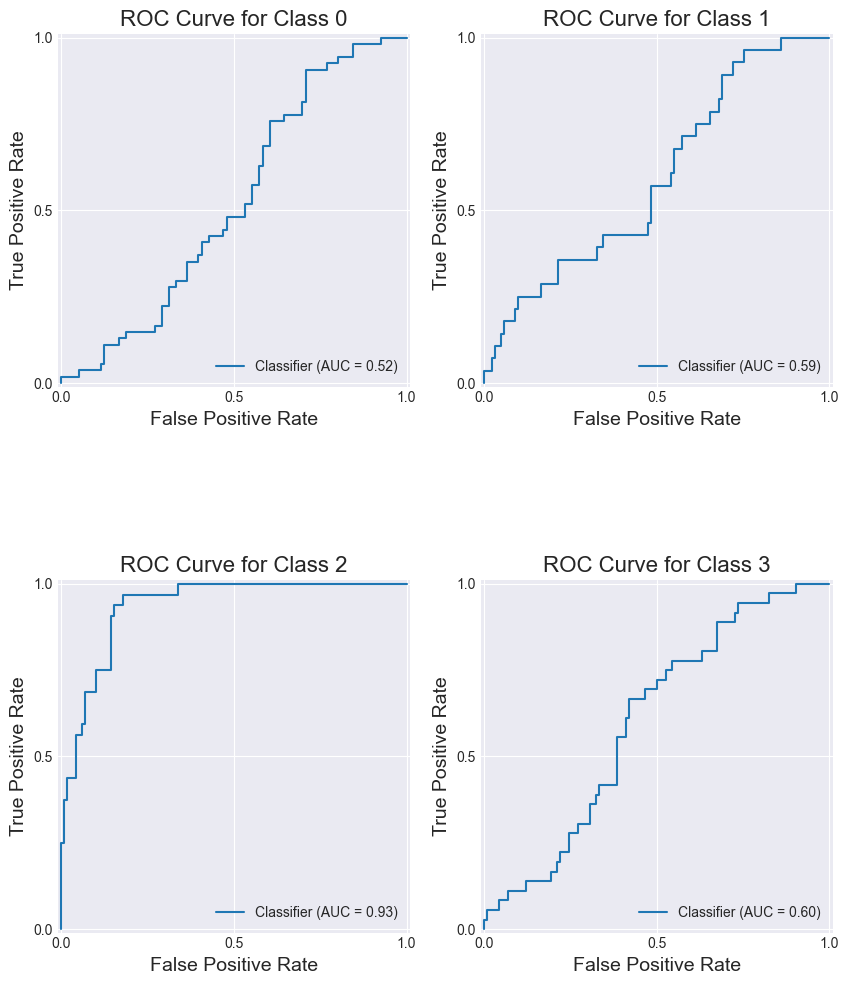

In [ ]:
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, axs = plt.subplots(2, 2, figsize=(10, 13))

for i, ax in enumerate(axs.flatten()):
    y_true_i = (y_true == i).int()
    y_pred_i = y_pred[:, i].detach().numpy()

    RocCurveDisplay.from_predictions(y_true_i, y_pred_i, ax=ax)  # Adjust based on your positive class

    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_title(f'ROC Curve for Class {i}', fontsize=16)